In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
!pip install split-folders

In [2]:
path="/kaggle/input/combined-project-data/Data"

In [3]:
import splitfolders
splitfolders.ratio(path, output="/kaggle/working/", 
                   seed=1, ratio=(.8,.2), 
                   group_prefix=None,)

Copying files: 900 files [00:04, 202.93 files/s]


In [4]:
class_labels=['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma']

In [5]:
def prepare_name_with_labels(folder_name,Y, dataset_type='train'):
    """ Prepare the file names (X) and the class labels (Y) from folder location of images.

        Args:
            folder_name: str
                Source folder's path

    """
#     Y=[]
    source_files = os.listdir(os.path.join("/kaggle/working/", dataset_type, folder_name))
    y_label = 0
    for i in range(len(class_labels)):
        if(folder_name == class_labels[i]):
            y_label = i
    for val in source_files:
        Y.append(y_label)

In [6]:
def load_images_from_folder(X,folder,size=(224,224)):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,size)
            X.append(img)
    print(len(X))

In [7]:
X=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/train/"+class_labels[i])
    load_images_from_folder(X,folder)
#     X.append(image)
    print("\n",i)

260

 0
390

 1
517

 2
718

 3


In [8]:
Y=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y)
    print(i)

0
1
2
3


In [9]:
X_test=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/val/"+class_labels[i])
    load_images_from_folder(X_test,folder)
#     X.append(image)
    print("\n",i)

66

 0
99

 1
131

 2
182

 3


In [10]:
Y_test=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y_test,dataset_type='val')
    print(i)

0
1
2
3


In [11]:
X = np.asarray(X)
Y = np.asarray(Y)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(718, 224, 224, 3)
(718,)
(182, 224, 224, 3)
(182,)


In [12]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc = OneHotEncoder().fit(Y.reshape(-1,1))
Y_label=drop_binary_enc.transform(Y.reshape(-1,1)).toarray()
print(Y_label.shape)

(718, 4)


In [13]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc_test = OneHotEncoder().fit(Y_test.reshape(-1,1))
Y_label_test=drop_binary_enc_test.transform(Y_test.reshape(-1,1)).toarray()
print(Y_label_test.shape)

(182, 4)


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
valid_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

In [15]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [16]:
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import concatenate
from numpy import argmax

In [17]:
from keras.models import load_model
densenet121_model=load_model("/kaggle/input/models/densenet121_model3.hdf5")
resnet50v2_model=load_model("/kaggle/input/models/resnet50v2_model4.hdf5")
vgg16_model=load_model("/kaggle/input/models/vgg16_model5.hdf5")

In [18]:
members=[densenet121_model,resnet50v2_model,vgg16_model]

In [19]:
from tensorflow.keras.layers import Input, Average
def create_ensemble_model(models):
#     models=[resnet_model, den_model , vgg_model, incep_model]
    model_input=Input(shape=(224,224,3))
    model_outputs=[mod(model_input) for mod in models]
    ensemble_output=Average()(model_outputs)
    ensemble_model=Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
    
    ensemble_model.compile(optimizer=optimizers.Adam(learning_rate= 0.001, decay= 1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    return ensemble_model

Results for fold 1
Epoch 1/25


2023-04-18 16:31:18.709509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0961 - acc: 0.9843
Epoch 1: val_acc improved from -inf to 0.98611, saving model to ./ensemble_model1.hdf5
18/18 [==============================] - 32s 823ms/step - loss: 0.0961 - acc: 0.9843 - val_loss: 0.0620 - val_acc: 0.9861
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0463 - acc: 0.9930
Epoch 2: val_acc improved from 0.98611 to 0.99306, saving model to ./ensemble_model1.hdf5
18/18 [==============================] - 5s 304ms/step - loss: 0.0463 - acc: 0.9930 - val_loss: 0.0512 - val_acc: 0.9931
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0365 - acc: 1.0000
Epoch 3: val_acc did not improve from 0.99306
18/18 [==============================] - 4s 235ms/step - loss: 0.0365 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9861
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0195 - acc: 0.9983
Epoch 4: val_acc did not improve from 0.99306
18/18 [===============

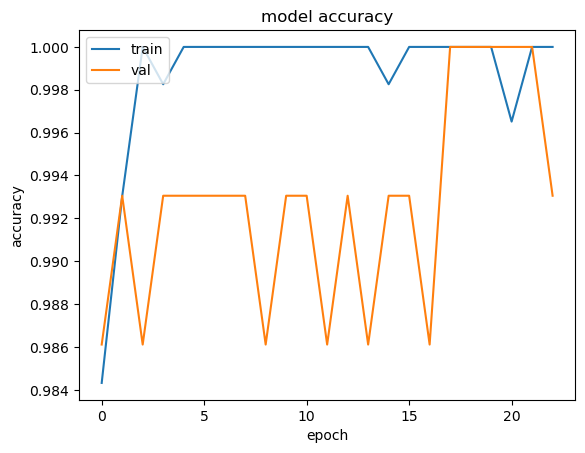

Model metrics for Round 1

6/6 [==============================] - 4s 712ms/step - loss: 0.2467 - acc: 0.9670
Accuracy 96.70329689979553
Loss 0.2467489093542099
Results for fold 2
Epoch 1/25


2023-04-18 16:33:31.879501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0315 - acc: 0.9895
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model2.hdf5
18/18 [==============================] - 18s 469ms/step - loss: 0.0315 - acc: 0.9895 - val_loss: 3.8020e-04 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0197 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0197 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0176 - acc: 0.9983
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0176 - acc: 0.9983 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0142 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss:

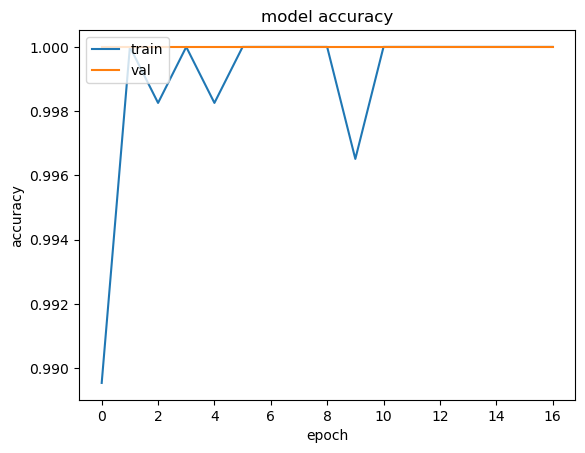

Model metrics for Round 2

6/6 [==============================] - 1s 160ms/step - loss: 0.2470 - acc: 0.9560
Accuracy 95.60439586639404
Loss 0.2469562441110611
Results for fold 3
Epoch 1/25


2023-04-18 16:35:00.458321: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0099 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model3.hdf5
18/18 [==============================] - 19s 479ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0136 - acc: 0.9983
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0.0136 - acc: 0.9983 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0094 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 228ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0128 - acc: 0.9983
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0.0

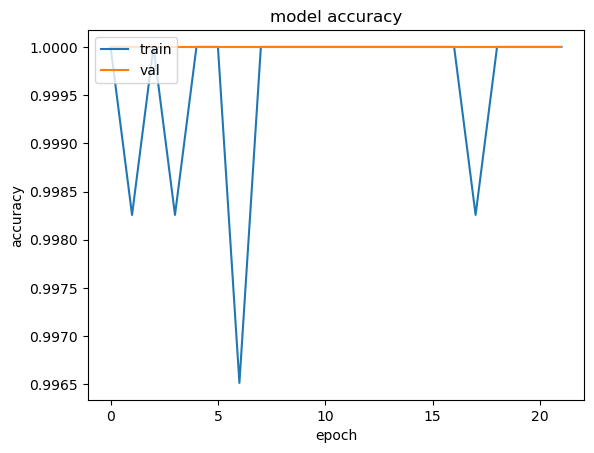

Model metrics for Round 3

6/6 [==============================] - 1s 160ms/step - loss: 0.2391 - acc: 0.9670
Accuracy 96.70329689979553
Loss 0.23912598192691803
Results for fold 4
Epoch 1/25


2023-04-18 16:36:50.461455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0138 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model4.hdf5
18/18 [==============================] - 24s 786ms/step - loss: 0.0138 - acc: 1.0000 - val_loss: 6.4241e-04 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0109 - acc: 0.9983
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 229ms/step - loss: 0.0109 - acc: 0.9983 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0093 - acc: 0.9965
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 228ms/step - loss: 0.0093 - acc: 0.9965 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0070 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss:

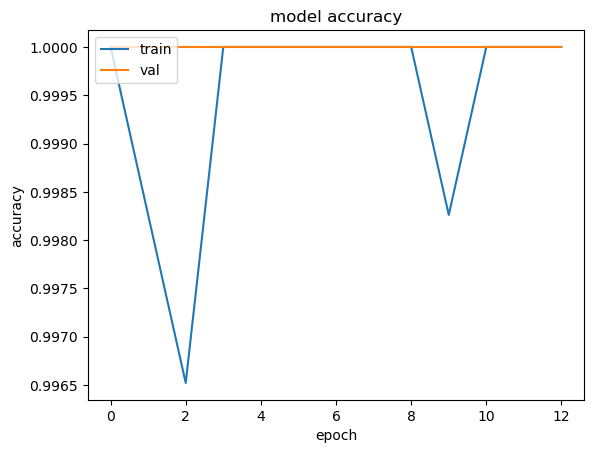

Model metrics for Round 4

6/6 [==============================] - 1s 160ms/step - loss: 0.2464 - acc: 0.9780
Accuracy 97.80219793319702
Loss 0.2464253157377243
Results for fold 5
Epoch 1/25


2023-04-18 16:38:07.521414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0088 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model5.hdf5
18/18 [==============================] - 19s 477ms/step - loss: 0.0088 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0082 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 1.8465e-07 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0089 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0077 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 229ms/step

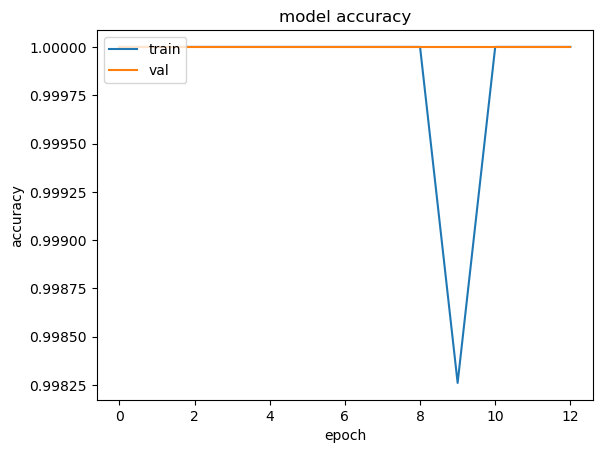

Model metrics for Round 5

6/6 [==============================] - 1s 162ms/step - loss: 0.3014 - acc: 0.9780
Accuracy 97.80219793319702
Loss 0.3014262318611145


In [20]:
fold_num = 0
skf_acc=[]
skf_loss=[]
for train_index, val_index in kfold.split(X, Y):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = 32)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = 32)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = 32)

    model=create_ensemble_model(members)
    
    checkpointer = ModelCheckpoint(filepath='./ensemble_model'+str(fold_num)+'.hdf5',
                            monitor='val_acc', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=12)
    
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy",result[1]*100)
    print("Loss",result[0])
    skf_acc.append(result[1])
    skf_loss.append(result[0])

In [21]:
from sklearn.model_selection import train_test_split
X_train_,X_val_,Y_train_,Y_val_=train_test_split(X,Y_label,train_size=0.8, random_state=123)

Epoch 1/25


2023-04-18 16:39:19.679509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.0000
Epoch 1: val_acc did not improve from 1.00000
18/18 [==============================] - 17s 406ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 9.1736e-04 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0058 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 1.2045e-07 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0097 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0097 - acc: 1.0000 - val_loss: 1.5191e-07 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0051 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0051 - acc: 1.0000 - val_loss:

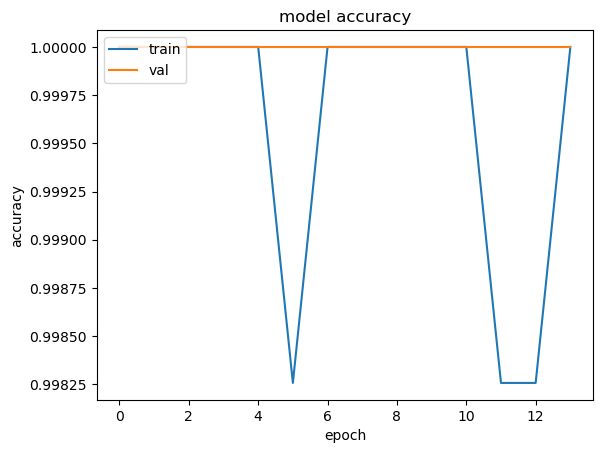

6/6 [==============================] - 1s 160ms/step - loss: 0.2528 - acc: 0.9670
Accuracy 96.70329689979553
Loss 0.2528475224971771


In [22]:
model2 = create_ensemble_model(members)

train_generator = train_datagen.flow(X_train_,
                                     Y_train_,
                                     batch_size = 32)
valid_generator = valid_datagen.flow(X_val_,
                                     Y_val_,
                                     batch_size = 32)
test_generator = test_datagen.flow(X_test,
                                   Y_label_test,
                                   batch_size = 32)


history=model2.fit(train_generator, 
                  epochs=25, 
                  verbose=1, 
                  validation_data=valid_generator, 
                  callbacks = [checkpointer, early_stopping])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
    
score=model2.evaluate(test_generator)
print("Accuracy",score[1]*100)
print("Loss",score[0])

In [23]:
from sklearn.model_selection import KFold
kf= KFold(n_splits=5,shuffle=True,random_state=1)

Results for fold 1.1
Epoch 1/25


2023-04-18 16:40:34.142541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0049 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model1.1.hdf5
18/18 [==============================] - 19s 533ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0090 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0050 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0056 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 229ms/step - loss: 0

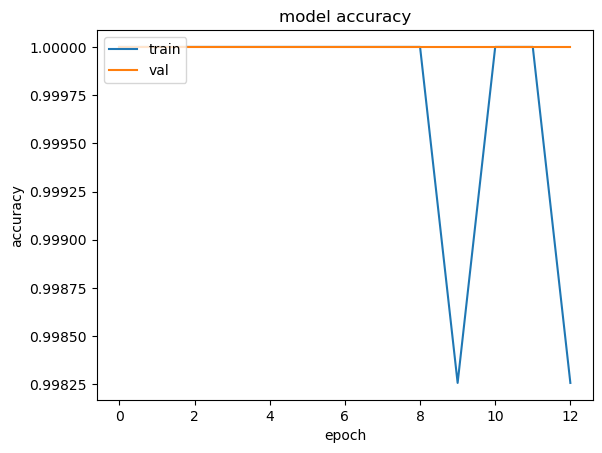

Model metrics for Round 1.1

6/6 [==============================] - 1s 160ms/step - loss: 0.2814 - acc: 0.9780
Accuracy 97.80219793319702
Loss 0.28139540553092957
Results for fold 2.1
Epoch 1/25


2023-04-18 16:41:46.772624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0092 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model2.1.hdf5
18/18 [==============================] - 18s 480ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0078 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 229ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0065 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0072 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 233ms/step - loss: 0

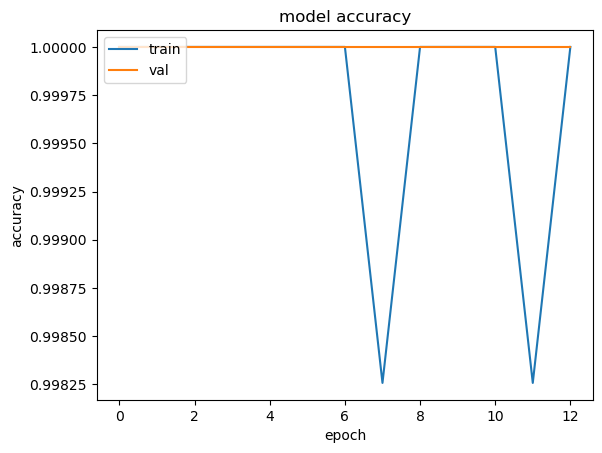

Model metrics for Round 2.1

6/6 [==============================] - 1s 163ms/step - loss: 0.2317 - acc: 0.9725
Accuracy 97.25274443626404
Loss 0.2317018359899521
Results for fold 3.1
Epoch 1/25


2023-04-18 16:42:58.849000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0099 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model3.1.hdf5
18/18 [==============================] - 18s 478ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0074 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0048 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 230ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0047 - acc: 0.9983
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 5s 259ms/st

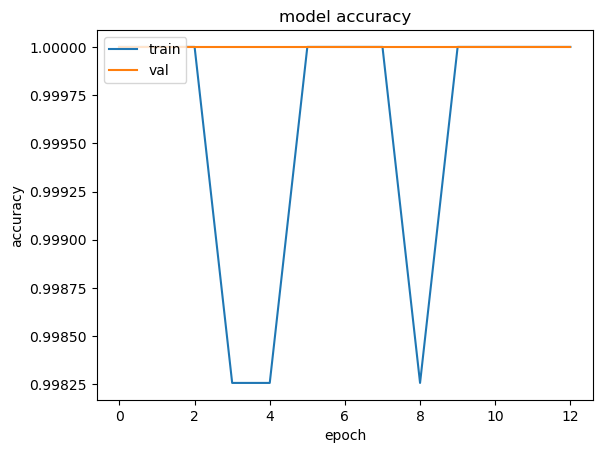

Model metrics for Round 3.1

6/6 [==============================] - 1s 159ms/step - loss: 0.3137 - acc: 0.9780
Accuracy 97.80219793319702
Loss 0.31369879841804504
Results for fold 4.1
Epoch 1/25


2023-04-18 16:44:11.099751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0059 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model4.1.hdf5
18/18 [==============================] - 19s 477ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 9.7290e-07 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0055 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 235ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0044 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 5s 257ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 1.3672e-07 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 228ms/st

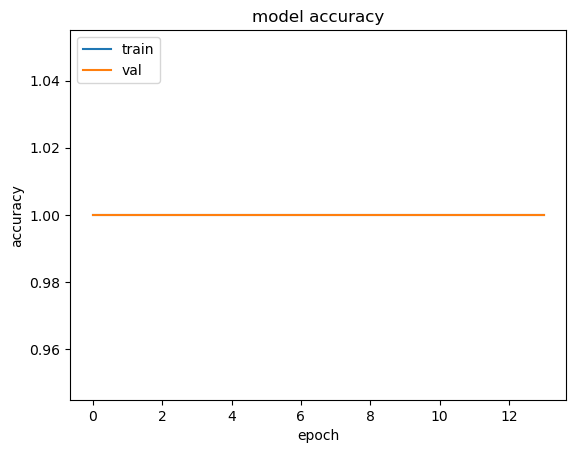

Model metrics for Round 4.1

6/6 [==============================] - 1s 162ms/step - loss: 0.3194 - acc: 0.9835
Accuracy 98.35164546966553
Loss 0.3193659484386444
Results for fold 5.1
Epoch 1/25


2023-04-18 16:45:28.068311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/sequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.0125 - acc: 0.9983
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./ensemble_model5.1.hdf5
18/18 [==============================] - 19s 484ms/step - loss: 0.0125 - acc: 0.9983 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.0088 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.0099 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 232ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0093 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
18/18 [==============================] - 4s 231ms/step - loss: 0

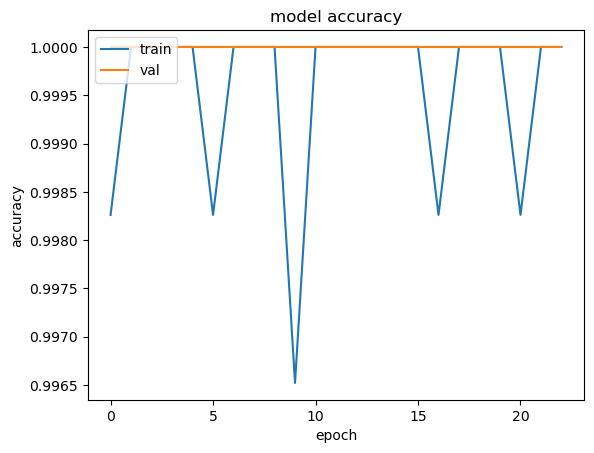

Model metrics for Round 5.1

6/6 [==============================] - 1s 159ms/step - loss: 0.2368 - acc: 0.9725
Accuracy 97.25274443626404
Loss 0.2368297427892685


In [24]:
fold_num = 0.1
kf_acc=[]
kf_loss=[]
for train_index, val_index in kf.split(X, Y):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = 32)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = 32)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = 32)

    model=create_ensemble_model(members)
    
    checkpointer = ModelCheckpoint(filepath='./ensemble_model'+str(fold_num)+'.hdf5',
                            monitor='val_acc', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=12)
    
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy",result[1]*100)
    print("Loss",result[0])
    kf_acc.append(result[1])
    kf_loss.append(result[0])

In [25]:
skf_acc=np.array(skf_acc)
skf_loss=np.array(skf_loss)
kf_acc=np.array(kf_acc)
kf_loss=np.array(kf_loss)

print("Accuracy and loss for StratifiedKfold")
print("Accuracy: ",sum(skf_acc)/len(skf_acc)*100)
print("Loss: ",sum(skf_loss)/len(skf_loss))
print("\nAccuracy and loss for Kfold")
print("Accuracy: ",sum(kf_acc)/len(kf_acc)*100)
print("Loss: ",sum(kf_loss)/len(kf_loss))
print("\nAccuracy and loss for Holdout")
print("Accuracy: ",score[1]*100)
print("Loss: ",score[0])

Accuracy and loss for StratifiedKfold
Accuracy:  96.92307710647583
Loss:  0.25613653659820557

Accuracy and loss for Kfold
Accuracy:  97.69230604171753
Loss:  0.27659834623336793

Accuracy and loss for Holdout
Accuracy:  96.70329689979553
Loss:  0.2528475224971771
